In [3]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict
# from tqdm.notebook import tqdm
from  sklearn.model_selection import train_test_split
pd.set_option('display.max_columns',None)
import gc
import json
import pickle
import sys
import dill

In [4]:
train = pd.read_feather('../features/mini_data/BASE_train.feather')

In [5]:
train['tags1'].value_counts()

143.0    2599635
136.0    2099193
131.0    1759379
73.0     1319652
53.0     1204948
          ...   
19.0        3630
117.0       2110
86.0        1055
160.0        664
38.0         300
Name: tags1, Length: 117, dtype: int64

In [42]:
TARGET = 'answered_correctly'

In [2]:
valid = pd.read_feather('../data/oof/034_simple_lgb.feather')

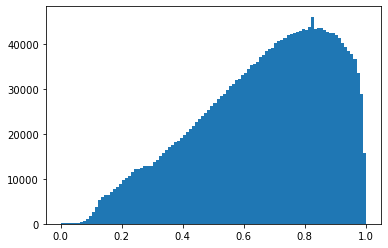

In [6]:
plt.hist(valid['pred'],bins=100)
plt.show()

In [11]:
valid

,row_id,pred
0,1874,0.822978
1,1875,0.300015
2,1876,0.359283
3,1877,0.631950
4,1878,0.329863
...,...,...
2451416,101197601,0.791046
2451417,101197602,0.596080
2451418,101197603,0.385574
2451419,101197604,0.450036


In [30]:
valid_ans = pd.read_feather('../features/mini_data/BASE_valid.feather')

In [ ]:
t = pd.read_feather('../features/mini_data/BASE_valid.feather')

In [33]:
valid_ans['prior_question_had_explanation'].value_counts()

1    2236120
0     215301
Name: prior_question_had_explanation, dtype: int64

In [47]:
task_usr = valid_ans[[TARGET,'task_container_id','user_id']].groupby(['user_id','task_container_id']).agg(['mean','count']).reset_index()

In [49]:
task_usr.columns = ['user_id','task_container_id','mean','count']

In [53]:
task_usr[task_usr['count'] == 1]['mean'].mean()

0.6578801430426858

In [60]:
task_usr[task_usr['count'] >= 3]['mean'].mean()

0.6740875007882983

In [63]:
valid_ans[(valid_ans['user_id'] == 24418) & (valid_ans['task_container_id'] == 5)]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of,small_quenstion,prior_question_elapsed_time_mean
7,1881,100241,24418,3363,0,5,0,0,4000.0,0,3363.0,3.0,4,74 103 29,74.0,103.0,29.0,NaN,NaN,NaN,NaN,None,NaN,0.0,4000.0
8,1882,100241,24418,3365,0,5,2,1,4000.0,0,3363.0,2.0,4,136 103 29,136.0,103.0,29.0,NaN,NaN,NaN,NaN,None,NaN,2.0,4000.0
9,1883,100241,24418,3364,0,5,1,1,4000.0,0,3363.0,1.0,4,136 103 29,136.0,103.0,29.0,NaN,NaN,NaN,NaN,None,NaN,1.0,4000.0


In [1]:
valid_ans['tags1'].value_counts()

NameError: name 'valid_ans' is not defined

In [67]:
valid_ans['count'] = 1
task_count = valid_ans[['count','task_container_id','user_id']].groupby(['user_id','task_container_id']).agg(['count']).reset_index()

In [86]:
task_count.columns = ['user_id','task_container_id','task_container_count']

In [87]:
valid_ans = pd.merge(valid_ans,task_count,on=['user_id','task_container_id'],how='left')

In [90]:
valid_ans[[TARGET,'task_container_count']].groupby('task_container_count').mean()

,answered_correctly
task_container_count,
1,0.657880
2,0.796368
3,0.675542
4,0.667371
5,0.692359


In [92]:
valid_ans['task_container_id'].value_counts()

14      17605
15      17505
4       15127
5       15073
6       15062
        ...  
9079        1
8925        1
9072        1
9321        1
8957        1
Name: task_container_id, Length: 9859, dtype: int64

In [93]:
dd = pd.read_feather('../features/kernel_mini_data/GROUP_BY_train.feather')

In [94]:
dd

,task_container_count
0,1
1,1
2,1
3,1
4,3
...,...
25732022,1
25732023,1
25732024,1
25732025,1


In [17]:
valid_ans = pd.merge(valid_ans,valid,on='row_id',how='left')

In [22]:
valid_ans['diff'] = valid_ans[TARGET] - valid_ans['pred']

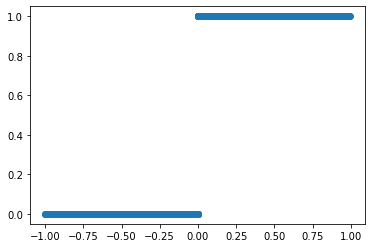

In [23]:
plt.scatter(valid_ans['diff'],valid_ans[TARGET])
plt.show()

In [27]:
valid_ans[valid_ans['diff'] < -0.9]['part'].value_counts()

5    4481
2    3855
6    2431
3    2413
1    2284
4    1776
7    1149
Name: part, dtype: int64

In [29]:
valid_ans[valid_ans['diff'] > 0.9]['part'].value_counts()

5    128
7     72
6     40
4     38
2     27
3     21
1      8
Name: part, dtype: int64

In [28]:
valid_ans['part'].value_counts()

5    1017825
2     462805
6     256191
3     215430
4     196022
1     180071
7     123077
Name: part, dtype: int64

In [25]:
valid_ans.sort_values('diff')

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of,small_quenstion,prior_question_elapsed_time_mean,pred,diff
2091628,87331204,33094223612,1858014392,7946,0,2027,1,0,20000.0,1,7946.0,2.0,1,131 149 81,131.0,149.0,81.0,NaN,NaN,NaN,NaN,None,NaN,0.0,20000.0,0.998477,-0.998477
944910,40161432,17289136417,854518136,10574,0,3086,3,0,19000.0,1,10574.0,0.0,1,131 68 92,131.0,68.0,92.0,NaN,NaN,NaN,NaN,None,NaN,0.0,19000.0,0.998109,-0.998109
584762,25102539,17603555210,536909391,10477,0,2089,2,0,25000.0,1,10477.0,0.0,1,131 149 29,131.0,149.0,29.0,NaN,NaN,NaN,NaN,None,NaN,0.0,25000.0,0.997150,-0.997150
1699915,71409670,15365252108,1519230159,742,0,2325,3,0,15000.0,1,742.0,0.0,2,143 176 38 81,143.0,176.0,38.0,81.0,NaN,NaN,NaN,None,NaN,0.0,15000.0,0.996933,-0.996933
1294908,54328659,117243979,1151429516,7963,0,69,1,0,16000.0,1,7963.0,2.0,1,131 93 38,131.0,93.0,38.0,NaN,NaN,NaN,NaN,None,NaN,0.0,16000.0,0.996889,-0.996889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2418252,99875615,2757676001,2120015219,7979,0,654,0,1,3000.0,1,7979.0,0.0,1,51 131 162 38,51.0,131.0,162.0,38.0,NaN,NaN,NaN,None,NaN,0.0,3000.0,0.024570,0.975430
2390825,98781249,6490284033,2095348710,541,0,189,3,1,17000.0,1,541.0,3.0,2,62 90 142 81 29,62.0,90.0,142.0,81.0,29.0,NaN,NaN,None,NaN,0.0,17000.0,0.013974,0.986026
1764812,74416253,16942902992,1583784120,482,0,890,3,1,8000.0,1,482.0,3.0,2,143 20 81 29,143.0,20.0,81.0,29.0,NaN,NaN,NaN,None,NaN,0.0,8000.0,0.011093,0.988907
1679725,70356743,16954162826,1496456383,1246,0,1173,3,1,16000.0,1,1246.0,3.0,2,2 32 92 29,2.0,32.0,92.0,29.0,NaN,NaN,NaN,None,NaN,0.0,16000.0,0.009558,0.990442


In [41]:
with open('../features/kernel_data/loop_feats_mini.dill','rb') as f:
    dd = dill.load(f)

In [43]:
next(iter(dd['answered_correctly_uq']))

124

In [48]:
# dd['answered_correctly_uq'][124]

In [46]:
# dd['answered_correctly_uq'][124]

In [49]:
# dd[124.0]

In [20]:
for v in dd:
    v

In [36]:
ddd = defaultdict(lambda: defaultdict(int))

In [37]:
ddd[0][0] = [0,0]
ddd[1.0][1.01] = [3,0]

In [38]:
ddd

defaultdict(<function __main__.<lambda>()>,
            {0: defaultdict(int, {0: [0, 0]}),
             1.0: defaultdict(int, {1.01: [3, 0]})})

In [23]:
v[2147362683.0]

IndexError: invalid index to scalar variable.

In [18]:
# for i in range(1,40):
#     print(i)

#     df = pd.read_feather(f'../data/train_valid/cv{i}_train.feather')
#     print(df.shape)

1
(98730332, 1)
2
(96230332, 1)
3
(93730332, 1)
4
(91230332, 1)
5
(88730332, 1)
6
(86230332, 1)
7
(83730332, 1)
8
(81230332, 1)
9
(78730332, 1)
10
(76230332, 1)
11
(73730332, 1)
12
(71230332, 1)
13
(68730332, 1)
14
(66230332, 1)
15
(63730332, 1)
16
(61230332, 1)
17
(58730332, 1)
18
(56230332, 1)
19
(53730332, 1)
20
(51230332, 1)
21
(48730332, 1)
22
(46230332, 1)
23
(43730332, 1)
24
(41230332, 1)
25
(38730332, 1)
26
(36230332, 1)
27
(33730332, 1)
28
(31230332, 1)
29
(28730332, 1)
30
(26230332, 1)
31
(23730332, 1)
32
(21230332, 1)
33
(18730332, 1)
34
(16230332, 1)
35
(13730332, 1)
36
(11230332, 1)
37
(8730332, 1)
38
(6230332, 1)
39
(3730332, 1)


In [10]:
answered_correctly_uq_dic[0][1] = 1
answered_correctly_uq_dic[0][2] = 2

In [11]:
answered_correctly_uq_dic

defaultdict(<function __main__.<lambda>()>,
            {0: defaultdict(int, {1: 1, 2: 2})})

In [2]:
a = defaultdict(int)

a['bb'] = 1
a['cc'] = 2

In [3]:
a.keys()

dict_keys(['bb', 'cc'])

In [2]:
for i in range(1,41):
    print(f'{i}')
    df = pd.read_feather(f'../data/train_valid/cv{i}_train.feather')
    print(df.shape)

1
(98730332, 1)
2
(96230332, 1)
3
(93730332, 1)
4
(91230332, 1)
5
(88730332, 1)
6
(86230332, 1)
7
(83730332, 1)
8
(81230332, 1)
9
(78730332, 1)
10
(76230332, 1)
11
(73730332, 1)
12
(71230332, 1)
13
(68730332, 1)
14
(66230332, 1)
15
(63730332, 1)
16
(61230332, 1)
17
(58730332, 1)
18
(56230332, 1)
19
(53730332, 1)
20
(51230332, 1)
21
(48730332, 1)
22
(46230332, 1)
23
(43730332, 1)
24
(41230332, 1)
25
(38730332, 1)
26
(36230332, 1)
27
(33730332, 1)
28
(31230332, 1)
29
(28730332, 1)
30
(26230332, 1)
31
(23730332, 1)
32
(21230332, 1)
33
(18730332, 1)
34
(16230332, 1)
35
(13730332, 1)
36
(11230332, 1)
37
(8730332, 1)
38
(6230332, 1)
39
(3730332, 1)
40
(1230332, 1)


In [36]:
df = pd.read_feather('../features/mini_data/BASE_train.feather')

In [37]:
df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of,small_quenstion,prior_question_elapsed_time_mean
0,8511,0,44331,5542,0,0,1,0,NaN,0,5542.0,3.0,5,96,96.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,25295.100054
1,8512,35028,44331,5697,0,1,2,0,44000.0,0,5697.0,0.0,5,14,14.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,44000.000000
2,8513,61706,44331,5748,0,2,3,1,32000.0,0,5748.0,3.0,5,8,8.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,32000.000000
3,8514,85685,44331,376,0,3,0,0,24000.0,0,376.0,1.0,2,62 90 100 38 102,62.0,90.0,100.0,38.0,102.0,NaN,NaN,None,NaN,0.0,24000.000000
4,8515,141228,44331,5597,0,4,3,1,21000.0,0,5597.0,3.0,5,64,64.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,21000.000000


In [24]:
answered_correctly_u_count = defaultdict(int)
answered_correctly_u_sum = defaultdict(int)
elapsed_time_u_sum = defaultdict(int)
explanation_u_sum = defaultdict(int)
timestamp_u = defaultdict(list)
timestamp_u_incorrect = defaultdict(list)

# Question dictionaries
answered_correctly_q_count = defaultdict(int)
answered_correctly_q_sum = defaultdict(int)
elapsed_time_q_sum = defaultdict(int)
explanation_q_sum = defaultdict(int)

# Client Question dictionary
answered_correctly_uq = defaultdict(lambda: defaultdict(int))

In [27]:
answered_correctly_u_avg = np.zeros(len(df), dtype = np.float32)
elapsed_time_u_avg = np.zeros(len(df), dtype = np.float32)
explanation_u_avg = np.zeros(len(df), dtype = np.float32)
timestamp_u_recency_1 = np.zeros(len(df), dtype = np.float32)
timestamp_u_recency_2 = np.zeros(len(df), dtype = np.float32)
timestamp_u_recency_3 = np.zeros(len(df), dtype = np.float32)
timestamp_u_incorrect_recency = np.zeros(len(df), dtype = np.float32)
# -----------------------------------------------------------------------
# Question features
answered_correctly_q_avg = np.zeros(len(df), dtype = np.float32)
elapsed_time_q_avg = np.zeros(len(df), dtype = np.float32)
explanation_q_avg = np.zeros(len(df), dtype = np.float32)
# -----------------------------------------------------------------------
# User Question
answered_correctly_uq_count = np.zeros(len(df), dtype = np.int32)
# -----------------------------------------------------------------------

for num, row in tqdm(enumerate(df[['user_id', 'answered_correctly', 'content_id', 'prior_question_elapsed_time', 'prior_question_had_explanation', 'timestamp']].values)):

    # Client features assignation
    # ------------------------------------------------------------------
    if answered_correctly_u_count[row[0]] != 0:
        answered_correctly_u_avg[num] = answered_correctly_u_sum[row[0]] / answered_correctly_u_count[row[0]]
        elapsed_time_u_avg[num] = elapsed_time_u_sum[row[0]] / answered_correctly_u_count[row[0]]
        explanation_u_avg[num] = explanation_u_sum[row[0]] / answered_correctly_u_count[row[0]]
    else:
        answered_correctly_u_avg[num] = np.nan
        elapsed_time_u_avg[num] = np.nan
        explanation_u_avg[num] = np.nan

    if len(timestamp_u[row[0]]) == 0:
        timestamp_u_recency_1[num] = np.nan
        timestamp_u_recency_2[num] = np.nan
        timestamp_u_recency_3[num] = np.nan
    elif len(timestamp_u[row[0]]) == 1:
        timestamp_u_recency_1[num] = row[5] - timestamp_u[row[0]][0]
        timestamp_u_recency_2[num] = np.nan
        timestamp_u_recency_3[num] = np.nan
    elif len(timestamp_u[row[0]]) == 2:
        timestamp_u_recency_1[num] = row[5] - timestamp_u[row[0]][1]
        timestamp_u_recency_2[num] = row[5] - timestamp_u[row[0]][0]
        timestamp_u_recency_3[num] = np.nan
    elif len(timestamp_u[row[0]]) == 3:
        timestamp_u_recency_1[num] = row[5] - timestamp_u[row[0]][2]
        timestamp_u_recency_2[num] = row[5] - timestamp_u[row[0]][1]
        timestamp_u_recency_3[num] = row[5] - timestamp_u[row[0]][0]

    if len(timestamp_u_incorrect[row[0]]) == 0:
        timestamp_u_incorrect_recency[num] = np.nan
    else:
        timestamp_u_incorrect_recency[num] = row[5] - timestamp_u_incorrect[row[0]][0]

    # ------------------------------------------------------------------
    # Question features assignation
    if answered_correctly_q_count[row[2]] != 0:
        answered_correctly_q_avg[num] = answered_correctly_q_sum[row[2]] / answered_correctly_q_count[row[2]]
        elapsed_time_q_avg[num] = elapsed_time_q_sum[row[2]] / answered_correctly_q_count[row[2]]
        explanation_q_avg[num] = explanation_q_sum[row[2]] / answered_correctly_q_count[row[2]]
    else:
        answered_correctly_q_avg[num] = np.nan
        elapsed_time_q_avg[num] = np.nan
        explanation_q_avg[num] = np.nan
    # ------------------------------------------------------------------
    # Client Question assignation
    answered_correctly_uq_count[num] = answered_correctly_uq[row[0]][row[2]]
    # ------------------------------------------------------------------
    # ------------------------------------------------------------------
    # Client features updates
    answered_correctly_u_count[row[0]] += 1
    elapsed_time_u_sum[row[0]] += row[3]
    explanation_u_sum[row[0]] += int(row[4])
    if len(timestamp_u[row[0]]) == 3:
        timestamp_u[row[0]].pop(0)
        timestamp_u[row[0]].append(row[5])
    else:
        timestamp_u[row[0]].append(row[5])
    # ------------------------------------------------------------------
    # Question features updates
    answered_correctly_q_count[row[2]] += 1
    elapsed_time_q_sum[row[2]] += row[3]
    explanation_q_sum[row[2]] += int(row[4])
    # ------------------------------------------------------------------
    # Client Question updates
    answered_correctly_uq[row[0]][row[2]] += 1
    # ------------------------------------------------------------------
    # Flag for training and inference
    if True:
        # ------------------------------------------------------------------
        # Client features updates
        answered_correctly_u_sum[row[0]] += row[1]
        if row[1] == 0:
            if len(timestamp_u_incorrect[row[0]]) == 1:
                timestamp_u_incorrect[row[0]].pop(0)
                timestamp_u_incorrect[row[0]].append(row[5])
            else:
                timestamp_u_incorrect[row[0]].append(row[5])

        # ------------------------------------------------------------------
        # Question features updates
        answered_correctly_q_sum[row[2]] += row[1]
        # ------------------------------------------------------------------


user_df = pd.DataFrame({'answered_correctly_u_avg': answered_correctly_u_avg, 'elapsed_time_u_avg': elapsed_time_u_avg, 'explanation_u_avg': explanation_u_avg, 
                        'answered_correctly_q_avg': answered_correctly_q_avg, 'elapsed_time_q_avg': elapsed_time_q_avg, 'explanation_q_avg': explanation_q_avg, 
                        'answered_correctly_uq_count': answered_correctly_uq_count, 'timestamp_u_recency_1': timestamp_u_recency_1, 'timestamp_u_recency_2': timestamp_u_recency_2,
                        'timestamp_u_recency_3': timestamp_u_recency_3, 'timestamp_u_incorrect_recency': timestamp_u_incorrect_recency})

df = pd.concat([df, user_df], axis = 1)

8568610it [02:10, 65731.72it/s]


In [33]:
# answered_correctly_q_sum

In [28]:
df

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of,small_quenstion,prior_question_elapsed_time_mean,answered_correctly_u_avg,elapsed_time_u_avg,explanation_u_avg,answered_correctly_q_avg,elapsed_time_q_avg,explanation_q_avg,answered_correctly_uq_count,timestamp_u_recency_1,timestamp_u_recency_2,timestamp_u_recency_3,timestamp_u_incorrect_recency
0,8511,0,44331,5542,0,0,1,0,NaN,0,5542.0,3.0,5,96,96.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,25295.100054,0.585616,NaN,0.958904,0.714286,NaN,0.642857,2,-4.661118e+09,-4.661118e+09,-4.661118e+09,-4.660926e+09
1,8512,35028,44331,5697,0,1,2,0,44000.0,0,5697.0,0.0,5,14,14.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,44000.000000,0.583618,NaN,0.955631,0.425000,30365.000000,0.900000,1,3.502800e+04,-4.661083e+09,-4.661083e+09,3.502800e+04
2,8513,61706,44331,5748,0,2,3,1,32000.0,0,5748.0,3.0,5,8,8.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,32000.000000,0.581633,NaN,0.952381,0.733333,25700.000000,0.333333,1,2.667800e+04,6.170600e+04,-4.661057e+09,2.667800e+04
3,8514,85685,44331,376,0,3,0,0,24000.0,0,376.0,1.0,2,62 90 100 38 102,62.0,90.0,100.0,38.0,102.0,NaN,NaN,None,NaN,0.0,24000.000000,0.583051,NaN,0.949153,0.697987,22033.556641,0.214765,1,2.397900e+04,5.065700e+04,8.568500e+04,5.065700e+04
4,8515,141228,44331,5597,0,4,3,1,21000.0,0,5597.0,3.0,5,64,64.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,21000.000000,0.581081,NaN,0.945946,0.804878,26417.683594,0.939024,2,5.554300e+04,7.952200e+04,1.062000e+05,5.554300e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8568605,101228658,219919,2147463192,6318,0,12,3,0,9000.0,1,6318.0,0.0,5,124,124.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,9000.000000,0.666667,NaN,0.333333,0.599515,NaN,0.908453,0,1.550200e+04,3.232100e+04,5.276300e+04,1.578220e+05
8568606,101228659,233275,2147463192,4756,0,13,0,0,6000.0,1,4756.0,2.0,5,96,96.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,6000.000000,0.615385,NaN,0.384615,0.724382,NaN,0.727915,0,1.335600e+04,2.885800e+04,4.567700e+04,1.335600e+04
8568607,101228660,253051,2147463192,9376,0,14,0,0,5000.0,1,9376.0,2.0,5,96,96.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,5000.000000,0.571429,NaN,0.428571,0.859195,24649.902344,0.991379,0,1.977600e+04,3.313200e+04,4.863400e+04,1.977600e+04
8568608,101228661,272506,2147463192,4447,0,15,1,1,10000.0,1,4447.0,1.0,5,47,47.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,10000.000000,0.533333,NaN,0.466667,0.707341,NaN,0.979717,0,1.945500e+04,3.923100e+04,5.258700e+04,1.945500e+04


In [29]:
answered_correctly_u_avg

array([0.5856164 , 0.58361775, 0.5816327 , ..., 0.5714286 , 0.53333336,
       0.5625    ], dtype=float32)

In [2]:
d = pd.read_feather('../features/kernel_data/content_dict.feather')

In [3]:
d.shape

(86867031, 4)

In [3]:
with open('../features/kernel_data/user_bundle_dict_sum.pkl','rb') as f:
    bundle_sum = pickle.load(f)

In [10]:
with open('../features/kernel_data/user_bundle_dict_count.pkl','rb') as f:
    bundle_count = pickle.load(f)

In [8]:
bundle_sum_key = list(bundle_sum.keys())
bundle_sum_values = list(bundle_sum.values())

In [11]:
bundle_count_key = list(bundle_count.keys())
bundle_count_values = list(bundle_count.values())

In [12]:
df_bundle_sum = pd.DataFrame()
df_bundle_sum['user_id_bundle'] = bundle_sum_key
df_bundle_sum['answered_correctly_sum_user_bundle'] = bundle_sum_values

In [13]:
df_bundle_count = pd.DataFrame()
df_bundle_count['user_id_bundle'] = bundle_count_key
df_bundle_count['count_user_bundle'] = bundle_count_values

In [14]:
df_bundle_sum.head()

,user_id_bundle,answered_correctly_sum_user_bundle
0,115-5692.0,1
1,115-5716.0,1
2,115-128.0,1
3,115-7860.0,1
4,115-7922.0,1


In [15]:
df_bundle = pd.merge(df_bundle_sum,df_bundle_count,on='user_id_bundle',how='left')

In [16]:
df_bundle['answered_correctly_avg_user_bundle'] = df_bundle['answered_correctly_sum_user_bundle'] / df_bundle['count_user_bundle']

In [17]:
df_bundle.head()

,user_id_bundle,answered_correctly_sum_user_bundle,count_user_bundle,answered_correctly_avg_user_bundle
0,115-5692.0,1,1,1.0
1,115-5716.0,1,1,1.0
2,115-128.0,1,1,1.0
3,115-7860.0,1,1,1.0
4,115-7922.0,1,1,1.0


In [53]:
df_bundle = pd.concat([df_bundle_sum.reset_index(drop=True), df_bundle_count.set_index('user_id_bundle').reindex(df_bundle_sum['user_id_bundle'].values).reset_index(drop=True)], axis=1)

In [54]:
df_bundle

,user_id_bundle,answered_correctly_sum_user_bundle,count_user_bundle
0,115-5692.0,1,1
1,115-5716.0,1,1
2,115-128.0,1,1
3,115-7860.0,1,1
4,115-7922.0,1,1
...,...,...,...
66697980,2147482888-3586.0,1,1
66697981,2147482888-6341.0,1,1
66697982,2147482888-4212.0,1,1
66697983,2147482888-6343.0,0,1


In [32]:
df_bundle_sum['user_id_bundle'].values

array(['115-5692.0', '115-5716.0', '115-128.0', ..., '2147482888-4212.0',
       '2147482888-6343.0', '2147482888-7995.0'], dtype=object)

In [51]:
df_bundle_count[df_bundle_count['user_id_bundle'].isin(['115-5692.0'])]

,user_id_bundle,count_user_bundle
0,115-5692.0,1


In [52]:
df_bundle_count.reindex(['115-5692.0'])

,user_id_bundle,count_user_bundle
115-5692.0,NaN,NaN


In [27]:
df_bundle =  pd.concat([df_bundle_count,df_bundle_sum],axis=1)

In [28]:
df_bundle

,user_id_bundle,count_user_bundle,user_id_bundle,answered_correctly_sum_user_bundle
0,115-5692.0,1,115-5692.0,1
1,115-5716.0,1,115-5716.0,1
2,115-128.0,1,115-128.0,1
3,115-7860.0,1,115-7860.0,1
4,115-7922.0,1,115-7922.0,1
...,...,...,...,...
66697980,2147482888-3586.0,1,2147482888-3586.0,1
66697981,2147482888-6341.0,1,2147482888-6341.0,1
66697982,2147482888-4212.0,1,2147482888-4212.0,1
66697983,2147482888-6343.0,1,2147482888-6343.0,0


In [24]:
df_bundle_count.head()

,user_id_bundle,count_user_bundle
0,115-5692.0,1
1,115-5716.0,1
2,115-128.0,1
3,115-7860.0,1
4,115-7922.0,1


In [25]:
df_bundle_sum.head()

,user_id_bundle,answered_correctly_sum_user_bundle
0,115-5692.0,1
1,115-5716.0,1
2,115-128.0,1
3,115-7860.0,1
4,115-7922.0,1


0

In [12]:
with open('../features/kernel_data/user_content_dict_sum.json','w') as f:
    json.dump(dic,f)

PermissionError: [Errno 13] Permission denied: '../features/kernel_data/user_content_dict_sum.json'

In [2]:
with open('../features/kernel_data/user_content_dict_sum.json','r') as f:
    j = json.load(f)

In [17]:
sys.getsizeof(j)

2684354672

In [2]:
df = pd.read_feather('../features/mini_data/BASE_train.feather')

In [57]:
import types

def imports():
    for name, val in globals().items():
        # module imports
        if isinstance(val, types.ModuleType):
            yield name, val
        # functions / callables
        if hasattr(val, '__call__'):
            yield name, val

noglobal = lambda fn: types.FunctionType(fn.__code__, dict(imports()))

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

a = 1

@noglobal
def f(b):
#     h5py.is_hdf5("a.tmp")
    # only np. shall be known, not numpy.
#     np.arange(4)
    #numpy.arange(4)
    # this var access shall break when called
#     print(a)
    print(a+b)

In [60]:
f(2)

NameError: name 'a' is not defined

In [2]:
def _reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
def add_user_feats(df, answered_correctly_sum_u_dict, count_u_dict):
    acsu = np.zeros(len(df), dtype=np.int32)
    cu = np.zeros(len(df), dtype=np.int32)
    for cnt,row in enumerate(tqdm(df[['user_id','answered_correctly']].values)):
        acsu[cnt] = answered_correctly_sum_u_dict[row[0]]
        cu[cnt] = count_u_dict[row[0]]
        answered_correctly_sum_u_dict[row[0]] += row[1]
        count_u_dict[row[0]] += 1
    user_feats_df = pd.DataFrame({'answered_correctly_sum_u':acsu, 'count_u':cu})
    user_feats_df['answered_correctly_avg_u'] = user_feats_df['answered_correctly_sum_u'] / user_feats_df['count_u']
    df = pd.concat([df, user_feats_df], axis=1)
    return df

In [11]:
train = pd.read_feather('../features/mini_data/BASE_train.feather')
valid = pd.read_feather('../features/mini_data/BASE_valid.feather')

In [14]:
answered_correctly_sum_u_dict = defaultdict(int)
count_u_dict = defaultdict(int)
train = add_user_feats(train, answered_correctly_sum_u_dict, count_u_dict)

100%|██████████| 8684585/8684585 [00:13<00:00, 665525.20it/s]


In [16]:
for cnt,row in enumerate(tqdm(valid[['user_id','answered_correctly']].values)):
#     acsu[cnt] = answered_correctly_sum_u_dict[row[0]]
    cnt
    row

100%|██████████| 2485495/2485495 [00:00<00:00, 2990517.94it/s]


In [24]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of,answered_correctly_sum_u,count_u,answered_correctly_avg_u
0,8511,0,44331,5542,0,0,1,0,NaN,NaN,5542.0,3.0,5,96,96.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0,0,NaN
1,8512,35028,44331,5697,0,1,2,0,44000.0,0.0,5697.0,0.0,5,14,14.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0,1,0.000000
2,8513,61706,44331,5748,0,2,3,1,32000.0,0.0,5748.0,3.0,5,8,8.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0,2,0.000000
3,8514,85685,44331,376,0,3,0,0,24000.0,0.0,376.0,1.0,2,62 90 100 38 102,62.0,90.0,100.0,38.0,102.0,NaN,NaN,None,NaN,1,3,0.333333
4,8515,141228,44331,5597,0,4,3,1,21000.0,0.0,5597.0,3.0,5,64,64.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,1,4,0.250000


In [29]:
# count_u_dict

In [25]:
len(answered_correctly_sum_u_dict)

52355

In [27]:
train['user_id'].nunique()

52355

In [35]:
answered_correctly_sum_u_dict = defaultdict(int)

In [36]:
answered_correctly_sum_u_dict[115] += 1

In [39]:
answered_correctly_sum_u_dict[115]

1

In [43]:
train['user_id_part'] = train['user_id'].astype(str) + '-' +train['part'].astype(str)

In [44]:
train

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of,answered_correctly_sum_u,count_u,answered_correctly_avg_u,user_id_part
0,8511,0,44331,5542,0,0,1,0,NaN,NaN,5542.0,3.0,5,96,96.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0,0,NaN,44331-5
1,8512,35028,44331,5697,0,1,2,0,44000.0,0.0,5697.0,0.0,5,14,14.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0,1,0.000000,44331-5
2,8513,61706,44331,5748,0,2,3,1,32000.0,0.0,5748.0,3.0,5,8,8.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0,2,0.000000,44331-5
3,8514,85685,44331,376,0,3,0,0,24000.0,0.0,376.0,1.0,2,62 90 100 38 102,62.0,90.0,100.0,38.0,102.0,NaN,NaN,None,NaN,1,3,0.333333,44331-2
4,8515,141228,44331,5597,0,4,3,1,21000.0,0.0,5597.0,3.0,5,64,64.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,1,4,0.250000,44331-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8684580,101228658,219919,2147463192,6318,0,12,3,0,9000.0,1.0,6318.0,0.0,5,124,124.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,9,14,0.642857,2147463192-5
8684581,101228659,233275,2147463192,4756,0,13,0,0,6000.0,1.0,4756.0,2.0,5,96,96.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,9,15,0.600000,2147463192-5
8684582,101228660,253051,2147463192,9376,0,14,0,0,5000.0,1.0,9376.0,2.0,5,96,96.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,9,16,0.562500,2147463192-5
8684583,101228661,272506,2147463192,4447,0,15,1,1,10000.0,1.0,4447.0,1.0,5,47,47.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,9,17,0.529412,2147463192-5


In [62]:
features_list = ['BASE','USER_ID','PART','USER_PART','CONTENT','USER_CONTENT','TAGS']

dfs = [pd.read_feather(f'../features/mini_data/{feature}_train.feather') for feature in features_list]
df = pd.concat(dfs,axis=1)

In [64]:
df

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of,answered_correctly_avg_user,answered_correctly_sum_user,count_user,answered_correctly_avg_part,answered_correctly_avg_user_part,answered_correctly_sum_user_part,count_user_part,answered_correctly_avg_content,answered_correctly_sum_content,content_num,answered_correctly_avg_user_content,answered_correctly_sum_user_content,count_user_content,answered_correctly_avg_tags1
0,8511,0,44331,5542,0,0,1,0,NaN,NaN,5542.0,3.0,5,96,96.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,0,0,0.602282,NaN,0,0,0.752778,271,360,NaN,0,0,0.607741
1,8512,35028,44331,5697,0,1,2,0,44000.0,0.0,5697.0,0.0,5,14,14.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.000000,0,1,0.602282,0.000000,0,1,0.579035,348,601,NaN,0,0,0.695563
2,8513,61706,44331,5748,0,2,3,1,32000.0,0.0,5748.0,3.0,5,8,8.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.000000,0,2,0.602282,0.000000,0,2,0.623457,303,486,NaN,0,0,0.610308
3,8514,85685,44331,376,0,3,0,0,24000.0,0.0,376.0,1.0,2,62 90 100 38 102,62.0,90.0,100.0,38.0,102.0,NaN,NaN,None,NaN,0.333333,1,3,0.701379,NaN,0,0,0.670373,1869,2788,NaN,0,0,0.735485
4,8515,141228,44331,5597,0,4,3,1,21000.0,0.0,5597.0,3.0,5,64,64.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.250000,1,4,0.602282,0.333333,1,3,0.828957,1168,1409,NaN,0,0,0.610358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8684580,101228658,219919,2147463192,6318,0,12,3,0,9000.0,1.0,6318.0,0.0,5,124,124.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.642857,9,14,0.602282,0.666667,8,12,0.598711,4458,7446,NaN,0,0,0.623604
8684581,101228659,233275,2147463192,4756,0,13,0,0,6000.0,1.0,4756.0,2.0,5,96,96.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.600000,9,15,0.602282,0.615385,8,13,0.722628,396,548,NaN,0,0,0.607741
8684582,101228660,253051,2147463192,9376,0,14,0,0,5000.0,1.0,9376.0,2.0,5,96,96.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.562500,9,16,0.602282,0.571429,8,14,0.860606,284,330,NaN,0,0,0.607741
8684583,101228661,272506,2147463192,4447,0,15,1,1,10000.0,1.0,4447.0,1.0,5,47,47.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.529412,9,17,0.602282,0.533333,8,15,0.707136,2091,2957,NaN,0,0,0.551334


In [65]:
df['answered_correctly_avg_user_content'].isnull().sum()

7692882

In [73]:
df['dd'] = 0
df.loc[df['user_id'] == 44331,'dd'] = 1

In [77]:
df_part_train = pd.read_feather(f'../features/mini_data/PART_train.feather')
df_part_valid = pd.read_feather(f'../features/mini_data/PART_valid.feather')

In [80]:
df_part_train['reading_part'].isnull().sum()

0

In [81]:
df_part_valid['reading_part'].isnull().sum()

0

In [3]:
train = pd.read_feather(f'../features/mini_data/BASE_train.feather')
valid = pd.read_feather(f'../features/mini_data/BASE_valid.feather')

In [87]:
train = pd.concat([train,df_part_train],axis=1)
valid = pd.concat([valid,df_part_train],axis=1)

In [89]:
train['reading_part'].isnull().sum()

0

In [90]:
valid['reading_part'].isnull().sum()

0

In [4]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of
0,8511,0,44331,5542,0,0,1,0,NaN,NaN,5542.0,3.0,5,96,96.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
1,8512,35028,44331,5697,0,1,2,0,44000.0,0.0,5697.0,0.0,5,14,14.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
2,8513,61706,44331,5748,0,2,3,1,32000.0,0.0,5748.0,3.0,5,8,8.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
3,8514,85685,44331,376,0,3,0,0,24000.0,0.0,376.0,1.0,2,62 90 100 38 102,62.0,90.0,100.0,38.0,102.0,NaN,NaN,None,NaN
4,8515,141228,44331,5597,0,4,3,1,21000.0,0.0,5597.0,3.0,5,64,64.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN


In [11]:
train['']
train[['type_of','part']].groupby('type_of').agg(['mean'])

,part
,mean
type_of,
concept,4.897378
intention,2.000000
solving question,3.748099
starter,5.000000


In [13]:
train['type_of'].fillna('NAN')

0          NAN
1          NAN
2          NAN
3          NAN
4          NAN
          ... 
8684580    NAN
8684581    NAN
8684582    NAN
8684583    NAN
8684584    NAN
Name: type_of, Length: 8684585, dtype: object

In [9]:
8568610/train.shape[0]

0.9866458788761927